# Kickstarter Success Prediction

This notebook demonstrates how to load, clean, and model Kickstarter project data to predict project success.

# 400,000 Kickstarter Projects

## Dataset Summary
- **Source**: Kaggle (toshimelonhead)  
- **Size**: ~400,000 rows, covering Kickstarter campaigns through about 2015

## Data Fields
- **project_id**, **name**, **desc**, **keywords**  
- **goal**, **country**, **currency**  
- **created_at**, **launched_at**, **deadline**, **state_changed_at**  
- **backers_count**, **final_status** (success/failure)


## 1. Load and Inspect Data

In [1]:
# Import all required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Define the filename for our dataset
file_path = 'e:/ML_Project/kickstarter-success-prediction/data/kickstarter.csv'

In [3]:
# Load the CSV file into a pandas DataFrame
# We use a try-except block to handle a potential FileNotFoundError
try:
    df = pd.read_csv(file_path)
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    print(f"❌ Error: The file '{file_path}' was not found.")
    print("Please make sure the dataset is in the same directory as your notebook, or provide the correct path.")

✅ Dataset loaded successfully!


In [4]:
# If the dataframe was loaded, let's inspect it
if 'df' in locals():
    print("\n--- First 5 Rows ---")
    display(df.head())


--- First 5 Rows ---


,Unnamed: 0,id,backers_count,blurb,currency,goal,launched_at,deadline,location.country,name,...,days_to_deadline,goal_USD,category_name,category_slug,blurb_length,location_type,location_country,location_state,location_displayable_name,binary_state
0,0,857125548,1,Exploring paint and its place in a digital world.,USD,2000.0,2015-03-19 22:34:57,2015-04-30 23:12:00,US,Remix,...,42,2000.0000,Digital Art,art,9,Town,US,NY,"New York, NY",failed
1,1,1038659700,2,Mike Fassio wants a side-by-side photo of me a...,USD,10.0,2014-07-17 01:55:07,2014-07-27 01:55:07,US,Photo of Grant and Hazel eating cake with bare...,...,10,10.0000,Digital Art,art,21,Town,US,WA,"Seattle, WA",failed
2,2,1238331911,0,I need your help to get a nice graphics tablet...,USD,900.0,2014-07-30 16:29:13,2014-08-29 16:29:13,US,Minecraft Digital Art/Animations,...,30,900.0000,Digital Art,art,12,Town,US,VA,"Moneta, VA",failed
3,3,189217262,0,I want to create a Nature Photograph Series of...,USD,900.0,2015-05-11 16:09:11,2015-05-31 16:09:11,US,Sacramento Nature Photograph Series,...,20,900.0000,Digital Art,art,17,Town,US,CA,"Sacramento, CA",failed
4,4,1260075071,1,I want to bring colour to the world in my own ...,GBP,15000.0,2015-02-06 21:52:02,2015-03-08 20:52:02,GB,North Africa art project - my dream,...,30,22801.6545,Digital Art,art,26,County,GB,England,"Essex, UK",failed


In [5]:
# DataFrame info
if 'df' in locals():
    print("\n--- Dataframe Info ---")
    df.info()


--- Dataframe Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430938 entries, 0 to 430937
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 430938 non-null  int64  
 1   id                         430938 non-null  int64  
 2   backers_count              430938 non-null  int64  
 3   blurb                      430936 non-null  object 
 4   currency                   430938 non-null  object 
 5   goal                       430938 non-null  float64
 6   launched_at                430938 non-null  object 
 7   deadline                   430938 non-null  object 
 8   location.country           429843 non-null  object 
 9   name                       430934 non-null  object 
 10  usd_pledged                430938 non-null  float64
 11  slug                       430938 non-null  object 
 12  spotlight                  430938 non-null  bool   
 13  staff

In [6]:
# Descriptive statistics
if 'df' in locals():
    print("\n--- Descriptive Statistics ---")
    display(df.describe())


--- Descriptive Statistics ---


,Unnamed: 0,id,backers_count,goal,usd_pledged,static_usd_rate,year,month,day,hour,days_to_deadline,goal_USD,blurb_length
count,430938.000000,4.309380e+05,430938.000000,4.309380e+05,4.309380e+05,430938.000000,430938.000000,430938.000000,430938.000000,430938.0,430938.000000,4.309380e+05,430938.000000
mean,2037.576459,1.073657e+09,138.950185,4.883624e+04,1.210324e+04,1.007943,2015.554108,6.192097,15.078280,0.0,34.295223,3.971246e+04,18.938532
std,1184.188600,6.194721e+08,1035.447040,1.103247e+06,1.047045e+05,0.228602,2.184330,3.371953,8.851132,0.0,12.380808,1.008321e+06,5.060098
min,0.000000,8.624000e+03,0.000000,1.000000e-02,0.000000e+00,0.008771,2009.000000,1.000000,1.000000,0.0,1.000000,1.000000e-02,1.000000
25%,1009.000000,5.365615e+08,2.000000,2.000000e+03,5.500000e+01,1.000000,2014.000000,3.000000,7.000000,0.0,30.000000,2.000000e+03,16.000000
50%,2026.000000,1.074770e+09,17.000000,5.000000e+03,9.220000e+02,1.000000,2016.000000,6.000000,15.000000,0.0,30.000000,5.000000e+03,20.000000
75%,3065.000000,1.609176e+09,71.000000,1.600000e+04,5.146987e+03,1.000000,2017.000000,9.000000,23.000000,0.0,38.000000,1.500000e+04,22.000000
max,4095.000000,2.147476e+09,219382.000000,1.000000e+08,2.033899e+07,1.716408,2019.000000,12.000000,31.000000,0.0,93.000000,1.523501e+08,41.000000


## 2. Data Cleaning and Feature Engineering

In [7]:
# Make a copy to keep the original dataframe safe
df_clean = df.copy()

In [8]:
# 1. Drop unnecessary and redundant columns
columns_to_drop = [
    'Unnamed: 0', 'id', 'blurb', 'name', 'currency', 'deadline',
    'launched_at', 'goal', 'category_slug', 'location.country',
    'location_typelocation_country', 'location_statelocation_displayable_name'
]
df_clean = df_clean.drop(columns=columns_to_drop, errors='ignore')

In [9]:
# 2. Rename 'days_to_deadline' to 'duration_days' if present
if 'days_to_deadline' in df_clean.columns:
    df_clean.rename(columns={'days_to_deadline': 'duration_days'}, inplace=True)

In [10]:
# 3. Filter for 'successful' and 'failed' projects only
valid_states = ['successful', 'failed']
df_clean = df_clean[df_clean['binary_state'].isin(valid_states)]
print(f"✅ Kept {len(df_clean)} rows with 'successful' or 'failed' states.")

✅ Kept 430938 rows with 'successful' or 'failed' states.


In [11]:
# 4. Convert the target variable 'binary_state' to numeric
df_clean['binary_state'] = df_clean['binary_state'].map({'successful': 1, 'failed': 0})

In [12]:
# Display the first 5 rows and info of our cleaned data
print("\n--- Cleaned Dataframe Head ---")
display(df_clean.head())

print("\n--- Cleaned Dataframe Info ---")
df_clean.info()


--- Cleaned Dataframe Head ---


,backers_count,usd_pledged,slug,spotlight,staff_pick,static_usd_rate,state,year,month,day,hour,duration_days,goal_USD,category_name,blurb_length,location_type,location_country,location_state,location_displayable_name,binary_state
0,1,25.00000,remix,False,False,1.00000,failed,2015,3,19,0,42,2000.0000,Digital Art,9,Town,US,NY,"New York, NY",0
1,2,6.00000,photo-of-grant-and-hazel-eating-cake-with-bare...,False,False,1.00000,failed,2014,7,17,0,10,10.0000,Digital Art,21,Town,US,WA,"Seattle, WA",0
2,0,0.00000,minecraft-digital-art-animations,False,False,1.00000,failed,2014,7,30,0,30,900.0000,Digital Art,12,Town,US,VA,"Moneta, VA",0
3,0,0.00000,nature-photograph-project,False,False,1.00000,failed,2015,5,11,0,20,900.0000,Digital Art,17,Town,US,CA,"Sacramento, CA",0
4,1,1.52011,north-africa-art-project-my-dream,False,False,1.52011,failed,2015,2,6,0,30,22801.6545,Digital Art,26,County,GB,England,"Essex, UK",0



--- Cleaned Dataframe Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430938 entries, 0 to 430937
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   backers_count              430938 non-null  int64  
 1   usd_pledged                430938 non-null  float64
 2   slug                       430938 non-null  object 
 3   spotlight                  430938 non-null  bool   
 4   staff_pick                 430938 non-null  bool   
 5   static_usd_rate            430938 non-null  float64
 6   state                      430938 non-null  object 
 7   year                       430938 non-null  int64  
 8   month                      430938 non-null  int64  
 9   day                        430938 non-null  int64  
 10  hour                       430938 non-null  int64  
 11  duration_days              430938 non-null  int64  
 12  goal_USD                   430938 non-null  float64
 1

## 3. Feature Selection and Data Splitting

In [13]:
# Define columns that leak information about the outcome
leaky_columns = ['usd_pledged', 'backers_count', 'spotlight', 'state']

# 1. Select the target variable 'y' and the feature set 'X'
y = df_clean['binary_state']

# Create our feature set 'X' by dropping the target and the leaky columns
X = df_clean.drop(columns=['binary_state', 'slug', 'location_displayable_name'] + leaky_columns)

print(f"✅ Dropped leaky columns: {leaky_columns}")

✅ Dropped leaky columns: ['usd_pledged', 'backers_count', 'spotlight', 'state']


In [14]:
# 2. Apply one-hot encoding to the categorical features
X = pd.get_dummies(X, drop_first=True)
print("✅ Categorical features converted to numerical format.")
print(f"New number of features after encoding: {X.shape[1]}")

✅ Categorical features converted to numerical format.
New number of features after encoding: 1732


In [15]:
# 3. Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- Data Split Complete ---")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


--- Data Split Complete ---
Shape of X_train: (344750, 1732)
Shape of X_test: (86188, 1732)


In [16]:
# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Data scaled successfully.")

✅ Data scaled successfully.


## 4. Model Training and Evaluation (Scaled Data)

In [17]:
# Train and evaluate the Logistic Regression model on scaled data only
print("🚀 Training the Logistic Regression model on scaled data...")
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
print("✅ Model training complete.")

# Evaluate the scaled model
y_pred_scaled = model.predict(X_test_scaled)
print(f"\nScaled Model Accuracy: {accuracy_score(y_test, y_pred_scaled):.4f}\n")
print(classification_report(y_test, y_pred_scaled, target_names=['Failed', 'Successful']))

🚀 Training the Logistic Regression model on scaled data...
✅ Model training complete.

Scaled Model Accuracy: 0.7454

              precision    recall  f1-score   support

      Failed       0.76      0.84      0.80     51397
  Successful       0.72      0.60      0.66     34791

    accuracy                           0.75     86188
   macro avg       0.74      0.72      0.73     86188
weighted avg       0.74      0.75      0.74     86188




--- Confusion Matrix (Scaled Data) ---


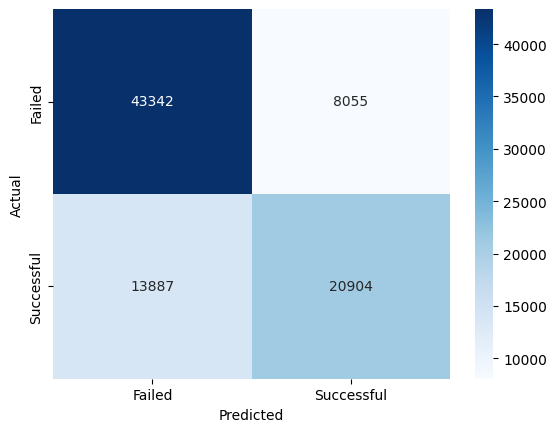

In [18]:
# Display the confusion matrix for the scaled model
print("\n--- Confusion Matrix (Scaled Data) ---")
cm = confusion_matrix(y_test, y_pred_scaled)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Failed', 'Successful'], yticklabels=['Failed', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 5. Random Forest Model

In [19]:
## 5. Random Forest Model (Corrected)

# NOTE: We are using the UN-SCALED data for the Random Forest.

print("🌳 Training the Random Forest model... (This may take a few minutes)")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model on the original (unscaled) training data
rf_model.fit(X_train, y_train)
print("✅ Model training complete.")

# Make predictions on the original (unscaled) test data
print("\n--- Random Forest Evaluation ---")
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Model Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}\n")
print(classification_report(y_test, y_pred_rf, target_names=['Failed', 'Successful']))

🌳 Training the Random Forest model... (This may take a few minutes)
✅ Model training complete.

--- Random Forest Evaluation ---
Random Forest Model Accuracy: 0.7799

              precision    recall  f1-score   support

      Failed       0.80      0.84      0.82     51397
  Successful       0.74      0.69      0.72     34791

    accuracy                           0.78     86188
   macro avg       0.77      0.77      0.77     86188
weighted avg       0.78      0.78      0.78     86188



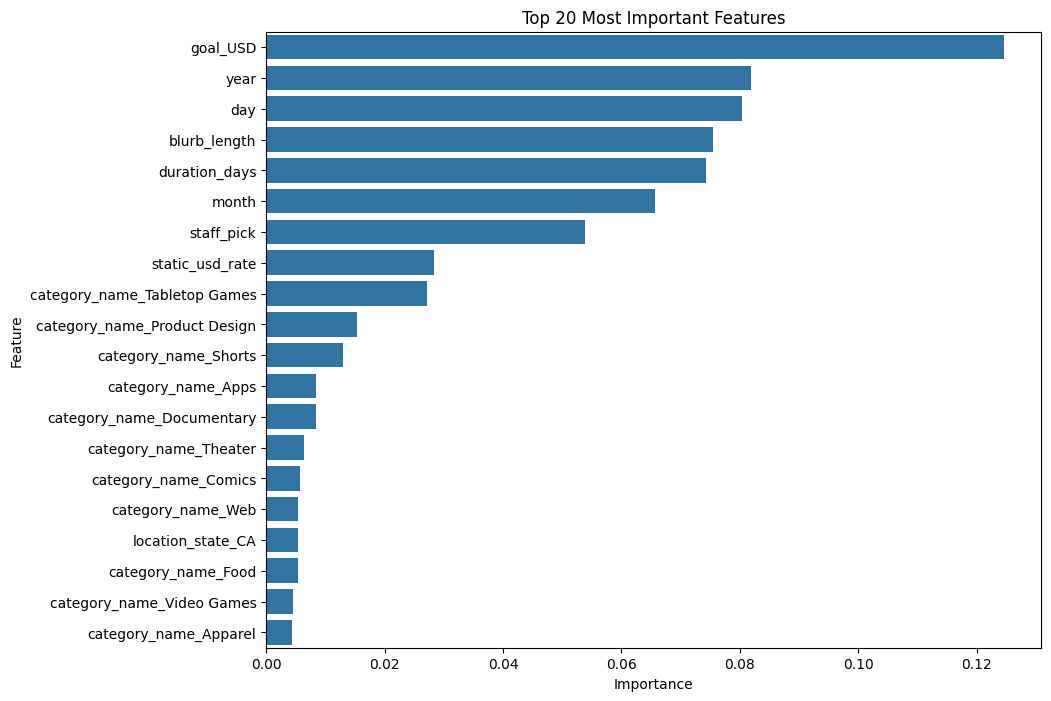

In [20]:
# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort by importance and get the top 20 features
top_20_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

# Plot the results
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_20_features)
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## HyperParaMeter Tuning

In [24]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Randomized Search to run on a single core
print("🔎 Starting hyperparameter tuning sequentially (n_jobs=1)...")
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                               n_iter=10, cv=3, verbose=2, random_state=42, 
                               n_jobs=1) # <--- The only change is here

# Fit the random search model (this will take longer now)
rf_random.fit(X_train, y_train)
print("✅ Tuning complete.")

# Get the best model
best_rf_model = rf_random.best_estimator_
print("\nBest Hyperparameters Found:")
print(rf_random.best_params_)

# Evaluate the new best model
print("\n--- Evaluation of Tuned Random Forest Model ---")
y_pred_best = best_rf_model.predict(X_test)
print(f"Tuned Model Accuracy: {accuracy_score(y_test, y_pred_best):.4f}\n")
print(classification_report(y_test, y_pred_best, target_names=['Failed', 'Successful']))

🔎 Starting hyperparameter tuning sequentially (n_jobs=1)...


KeyboardInterrupt: 

## Model 3 : XGBOOST

In [23]:
import xgboost as xgb

# 1. Initialize and train the XGBoost model
print("🚀 Training the XGBoost model...")
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model on the same unscaled data
xgb_model.fit(X_train, y_train)
print("✅ Model training complete.")

# 2. Make predictions and evaluate the model
print("\n--- XGBoost Evaluation ---")
y_pred_xgb = xgb_model.predict(X_test)
print(f"XGBoost Model Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}\n")
print(classification_report(y_test, y_pred_xgb, target_names=['Failed', 'Successful']))

🚀 Training the XGBoost model...


e:\ML_Project\kickstarter-success-prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:01:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model training complete.

--- XGBoost Evaluation ---
XGBoost Model Accuracy: 0.7749

              precision    recall  f1-score   support

      Failed       0.78      0.87      0.82     51397
  Successful       0.77      0.63      0.69     34791

    accuracy                           0.77     86188
   macro avg       0.77      0.75      0.76     86188
weighted avg       0.77      0.77      0.77     86188

